# Домашнее задание

Будем практиковаться на датасете недвижимости (sklearn.datasets.fetch_california_housing)

Ваша задача:
1. Создать Dataset для загрузки данных
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [2]:
!pip install torchmetrics

     |████████████████████████████████| 409 kB 33.9 MB/s 


In [3]:
import math
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch.nn.functional as F
import torch.nn as nn
import torchmetrics

In [4]:
housing = fetch_california_housing(data_home=None, download_if_missing=True, return_X_y=False, as_frame=True)
df = housing['frame']
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [5]:
features_list = housing['feature_names']
target = housing['target_names'][0]
X = df[features_list]
y = df[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [7]:
#стандартизация данных
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = torch.FloatTensor(X_train).float()
y_train = torch.FloatTensor(y_train.values).float()
X_test = torch.FloatTensor(X_test).float()
y_test = torch.FloatTensor(y_test.values).float()

In [8]:
class MyOwnCHousing(torch.utils.data.Dataset):
   
    def __init__(self, X_data, y_data):
        self._X = X_data
        self._y = y_data

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        X = self._X[idx] 
        y = self._y[idx] 
       
        return X, y

In [9]:
train_dataset = MyOwnCHousing(X_train, y_train)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          drop_last=True,
                          num_workers=0)

In [10]:
train_dataset[0], train_dataset[0][0].shape, train_dataset[0][1].shape 

((tensor([0.2081, 0.6863, 0.0243, 0.0226, 0.0379, 0.0011, 0.1775, 0.6096]),
  tensor(2.6800)),
 torch.Size([8]),
 torch.Size([]))

In [11]:
test_dataset = MyOwnCHousing(X_test, y_test)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=8,
                                          shuffle=False,
                                          drop_last=True,
                                          num_workers=0)

In [12]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation == "relu":
            return F.relu(x)
        if self.activation == "sigmoid":
            return F.sigmoid(x)
        raise RuntimeError
        
class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, 2*hidden_dim)
        self.dp1 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm1d(2*hidden_dim)
        self.fc2 = Perceptron(2*hidden_dim, hidden_dim)
        self.dp2 = nn.Dropout(0.2)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = Perceptron(hidden_dim, 1)
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.bn2(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.bn3(x)
        x = self.fc3(x)
        return x

In [13]:
# инициализация модели
net = FeedForward(8, 400)

# компиляция модели
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [14]:
num_epochs = 10

train_r2 = torchmetrics.R2Score()
test_r2 = torchmetrics.R2Score()

net.train()

for epoch in range(num_epochs):  
    
    running_loss, running_items = 0.0, 0.0
    
    for i, data in enumerate(train_loader):
        inputs, target = data[0], data[1]
        
        optimizer.zero_grad()
        outputs = net(inputs)
        train_r2(outputs.squeeze(), target)
        loss = criterion(outputs.squeeze(), target)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(target)
  
        # выводим статистику о процессе обучения
        if i % 60 == 0:    # печатаем каждые 60 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}, ', \
                  f'r2_train: {train_r2.compute().item():.3f}, ', end = ' ')
            running_loss, running_items = 0.0, 0.0
            train_r2.reset()

            for i, data in enumerate(test_loader):
                test_outputs = net(data[0])
                test_r2(test_outputs.squeeze(), data[1])
            
            print(f'r2_val: {test_r2.compute():.3f}')
            test_r2.reset()
            net.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/120]. Loss: 4.587,  r2_train: -2.739,  r2_val: -2.572
Epoch [1/10]. Step [61/120]. Loss: 1.372,  r2_train: -0.044,  r2_val: 0.367
Epoch [2/10]. Step [1/120]. Loss: 0.669,  r2_train: 0.387,  r2_val: 0.509
Epoch [2/10]. Step [61/120]. Loss: 0.680,  r2_train: 0.483,  r2_val: 0.542
Epoch [3/10]. Step [1/120]. Loss: 0.524,  r2_train: 0.540,  r2_val: 0.613
Epoch [3/10]. Step [61/120]. Loss: 0.553,  r2_train: 0.583,  r2_val: 0.625
Epoch [4/10]. Step [1/120]. Loss: 0.498,  r2_train: 0.612,  r2_val: 0.635
Epoch [4/10]. Step [61/120]. Loss: 0.496,  r2_train: 0.628,  r2_val: 0.650
Epoch [5/10]. Step [1/120]. Loss: 0.390,  r2_train: 0.641,  r2_val: 0.694
Epoch [5/10]. Step [61/120]. Loss: 0.454,  r2_train: 0.651,  r2_val: 0.710
Epoch [6/10]. Step [1/120]. Loss: 0.539,  r2_train: 0.672,  r2_val: 0.667
Epoch [6/10]. Step [61/120]. Loss: 0.411,  r2_train: 0.689,  r2_val: 0.683
Epoch [7/10]. Step [1/120]. Loss: 0.317,  r2_train: 0.662,  r2_val: 0.716
Epoch [7/10]. Step [61/120]. 

#### Протестируем разные метрики

In [15]:
def model_testing(model, optimizer, num_epochs):    
    
    train_r2 = torchmetrics.R2Score()
    test_r2 = torchmetrics.R2Score()
    
    r2_train_list = []
    r2_test_list = []
    
    for epoch in range(num_epochs):
        
        model.train()
        for i, data in enumerate(train_loader):
            inputs, target = data[0], data[1] # входные данные с лейблами
            # Обнуляем градиент
            optimizer.zero_grad()
            # Делаем предсказание
            outputs = model(inputs)
            #метрика
            batch_r2 = train_r2(outputs.squeeze(), target)
            # Рассчитываем лосс-функцию (функцию потерь)
            loss = criterion(outputs.squeeze(), target)
            # Вычисляем градиент
            loss.backward()
            # Обновляем веса (делаем шаг оптимайзера)
            optimizer.step()
        
        model.eval()
        for i, data in enumerate(test_loader):
            inputs, target = data[0], data[1]
            outputs = model(inputs)
            test_r2(outputs.squeeze(), target)

        # total r2 over all training batches
        total_train_r2 = train_r2.compute()
        # total r2 over all training batches
        total_test_r2 = test_r2.compute()
        
        r2_train_list.append(total_train_r2)
        r2_test_list.append(total_test_r2)
        print(f'Epoch {epoch+1}: r2_train = {total_train_r2}, r2_val = {total_test_r2}')

        #reset for next epoch
        train_r2.reset()
        test_r2.reset()
    
    return r2_train_list, r2_test_list

In [16]:
def show_metrics(r2_train_list, r2_test_list, optim):
    x = np.arange(1,11,1)
    y = r2_train_list
    y2 = r2_test_list

    plt.plot(x,y,label='R2_train')
    plt.plot(x,y2,label='R2_test')

    plt.title(f"Net with {optim}")   
    plt.ylabel('R2_score')   
    plt.xlabel('epochs')   
    plt.legend()
    plt.show()

SGD

In [17]:
model = FeedForward(8, 400)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.0)
r2_train_list_SGD, r2_test_list_SGD = model_testing(model, optimizer, 10)

Epoch 1: r2_train = -0.07998335361480713, r2_val = 0.4274411201477051
Epoch 2: r2_train = 0.38776856660842896, r2_val = 0.5420176386833191
Epoch 3: r2_train = 0.4726372957229614, r2_val = 0.57430100440979
Epoch 4: r2_train = 0.5139256715774536, r2_val = 0.5831491947174072
Epoch 5: r2_train = 0.5476119518280029, r2_val = 0.5925623774528503
Epoch 6: r2_train = 0.5823367834091187, r2_val = 0.6100304126739502
Epoch 7: r2_train = 0.6125624179840088, r2_val = 0.6668933033943176
Epoch 8: r2_train = 0.6390517950057983, r2_val = 0.6604312658309937
Epoch 9: r2_train = 0.6592569947242737, r2_val = 0.6935378313064575
Epoch 10: r2_train = 0.6723238229751587, r2_val = 0.6867774724960327


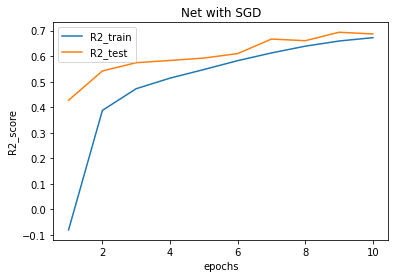

In [18]:
show_metrics(r2_train_list_SGD, r2_test_list_SGD, 'SGD')

Adam

In [19]:
model = FeedForward(8, 400)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
r2_train_list_Adam, r2_test_list_Adam = model_testing(model, optimizer, 10)

Epoch 1: r2_train = 0.17094355821609497, r2_val = 0.537878155708313
Epoch 2: r2_train = 0.5030573606491089, r2_val = 0.6066991090774536
Epoch 3: r2_train = 0.5924931764602661, r2_val = 0.6710516214370728
Epoch 4: r2_train = 0.6300135850906372, r2_val = 0.6761730909347534
Epoch 5: r2_train = 0.6498485207557678, r2_val = 0.7168112993240356
Epoch 6: r2_train = 0.6730341911315918, r2_val = 0.7245895862579346
Epoch 7: r2_train = 0.683568000793457, r2_val = 0.7084208726882935
Epoch 8: r2_train = 0.6886746287345886, r2_val = 0.6876895427703857
Epoch 9: r2_train = 0.6864084005355835, r2_val = 0.6406201720237732
Epoch 10: r2_train = 0.7024306058883667, r2_val = 0.6920178532600403


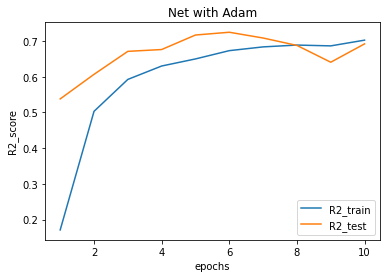

In [20]:
show_metrics(r2_train_list_Adam, r2_test_list_Adam, 'Adam')

RMSprop

In [21]:
model = FeedForward(8, 400)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
r2_train_list_RMS, r2_test_list_RMS = model_testing(model, optimizer, 10)

Epoch 1: r2_train = 0.16391408443450928, r2_val = 0.5472514629364014
Epoch 2: r2_train = 0.5335739850997925, r2_val = 0.5961681604385376
Epoch 3: r2_train = 0.5999305248260498, r2_val = 0.6488891243934631
Epoch 4: r2_train = 0.6375585198402405, r2_val = 0.7112250328063965
Epoch 5: r2_train = 0.6531606316566467, r2_val = 0.6528617739677429
Epoch 6: r2_train = 0.6783630847930908, r2_val = 0.639369010925293
Epoch 7: r2_train = 0.6891834139823914, r2_val = 0.722608208656311
Epoch 8: r2_train = 0.6819877028465271, r2_val = 0.6620222926139832
Epoch 9: r2_train = 0.7068423628807068, r2_val = 0.7074940204620361
Epoch 10: r2_train = 0.7117273807525635, r2_val = 0.690086841583252


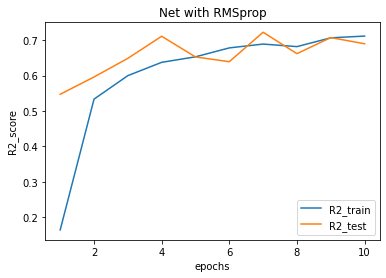

In [22]:
show_metrics(r2_train_list_RMS, r2_test_list_RMS, 'RMSprop')

In [23]:
metrics_result = pd.DataFrame([{'r2_train': r2_train_list_SGD[-1].item(), 'r2_test': r2_test_list_SGD[-1].item()},
                               {'r2_train': r2_train_list_Adam[-1].item(), 'r2_test': r2_test_list_Adam[-1].item()},
                               {'r2_train': r2_train_list_RMS[-1].item(), 'r2_test': r2_test_list_RMS[-1].item()}],
                              index =['SGD', 'Adam', 'RMSprop'], 
                              columns =['r2_train', 'r2_test'])

metrics_result.sort_values(by='r2_test', ascending=False)

,r2_train,r2_test
Adam,0.702431,0.692018
RMSprop,0.711727,0.690087
SGD,0.672324,0.686777


На тесте наилучшие показатели показал оптимизатор Adam